# **Laboratorio 04  SIS421**

### Nombre: Quispe Sucullani Jose David

### C.U. 111-376

### Link github:

##Contexto del Laboratorio


In [37]:
import torch
import torchvision
import os
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
from collections import Counter

import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##1: Lectura del Dataset

In [38]:
# Definir las transformaciones para las imágenes
from torchvision import datasets, transforms
import torch.utils.data

# Definir las transformaciones para el conjunto de datos FashionMNIST
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Redimensionar las imágenes a 28x28 píxeles para FashionMNIST
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize([0.5], [0.5])  # Normalizar entre [-1, 1] para las imágenes en escala de grises
])

# Cargar el conjunto de datos de entrenamiento y prueba de FashionMNIST con las transformaciones
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Mostrar la cantidad de imágenes de entrenamiento y prueba
print(f"Número de imágenes de entrenamiento: {len(train_data)}")
print(f"Número de imágenes de prueba: {len(test_data)}")

Número de imágenes de entrenamiento: 60000
Número de imágenes de prueba: 10000


In [39]:
# Function to handle dataset limiting (not needed for FashionMNIST, so keeping it as is but it won't be used directly)
def limit_dataset_size(root_dir, max_per_class=6000):
    # Dictionary to store paths of selected images by class
    limited_dataset = []

    # Iterate through subfolders in root_dir (each subfolder is a class)
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            # Get all images in the subfolder
            all_images = os.listdir(class_dir)
            # Filter to get only images, excluding other file types
            all_images = [os.path.join(class_name, img) for img in all_images if img.endswith(('.png', '.jpg', '.jpeg'))]
            # Randomly select 6000 images
            selected_images = random.sample(all_images, min(len(all_images), max_per_class))
            limited_dataset.extend(selected_images)

    return limited_dataset

In [40]:
# For FashionMNIST, we don't need a custom dataset class to limit size.
# The train_data loaded in the previous cell is already the full dataset.

# Verify the number of images in the training set (already done in the previous cell)
print(f"Número total de imágenes en el nuevo conjunto de entrenamiento: {len(train_data)}")

# Verify the number of images per class (FashionMNIST is balanced)
from collections import Counter
# Get the targets from the train_data object
class_distribution = Counter(train_data.targets.tolist())
print("Distribución de imágenes por clase:", class_distribution)

Número total de imágenes en el nuevo conjunto de entrenamiento: 60000
Distribución de imágenes por clase: Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})


In [41]:
# 1. Ver las etiquetas del dataset (clases):
# Ver las classes del dataset (etiquetas) for FashionMNIST
print(f"Clases en el conjunto de entrenamiento: {train_data.classes}")
print(f"Cantidad de clases: {len(train_data.classes)}")

Clases en el conjunto de entrenamiento: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Cantidad de clases: 10


In [42]:
import torch
from collections import Counter

# Verify the total number of images in the training set
num_total_images = len(train_data)
print(f"Número total de imágenes en el conjunto de entrenamiento: {num_total_images}")

# Verify the number of classes (labels) for FashionMNIST
num_classes = len(train_data.classes)
print(f"Número de clases: {num_classes}")

# Get the labels of all images (train_data.targets has the labels for each image)
class_distribution = Counter(train_data.targets.tolist())

# Show how many images are in each class
for class_idx, count in class_distribution.items():
    print(f"Clase '{train_data.classes[class_idx]}' tiene {count} imágenes")

Número total de imágenes en el conjunto de entrenamiento: 60000
Número de clases: 10
Clase 'Ankle boot' tiene 6000 imágenes
Clase 'T-shirt/top' tiene 6000 imágenes
Clase 'Dress' tiene 6000 imágenes
Clase 'Pullover' tiene 6000 imágenes
Clase 'Sneaker' tiene 6000 imágenes
Clase 'Sandal' tiene 6000 imágenes
Clase 'Trouser' tiene 6000 imágenes
Clase 'Shirt' tiene 6000 imágenes
Clase 'Coat' tiene 6000 imágenes
Clase 'Bag' tiene 6000 imágenes


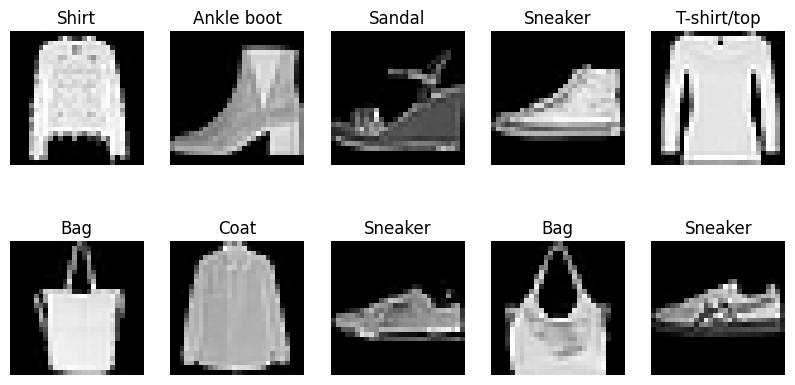

In [43]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Get the classes from the dataset
classes = train_data.classes

# Convert images and labels to numpy arrays for easier processing
def imshow(img):
    img = img / 2 + 0.5     # Desnormalize
    npimg = img.numpy()
    # FashionMNIST is grayscale, so we handle it differently
    if npimg.shape[0] == 1:
        npimg = np.transpose(npimg, (1, 2, 0))[:, :, 0] # Remove the single channel dimension
    else:
        npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

# Show 10 random images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    index = random.randint(0, len(train_data) - 1)
    img, label = train_data[index]
    plt.imshow(imshow(img), cmap='gray') # Use gray colormap for grayscale images
    plt.title(classes[label])
    plt.axis('off')

plt.show()

El dataset está formado por 6000 imágenes de baja resolución (50 x 50 píxeles, con tres canales de colores) y contiene 10 tipos prentas

In [44]:
# Define a custom class for the dataset that normalizes to [-1, 1] (already handled by transform)
# We can just use the loaded train_data directly with the DataLoader
class Prendas(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.imgs = torch.stack([img[0] for img in dataset])  # Load images as tensors
        # Normalization to [-1, 1] is done in the transform
        self.labels = torch.tensor([img[1] for img in dataset], dtype=torch.long)  # Image labels

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        return self.imgs[idx], self.labels[idx]

In [45]:
# We don't need to create a separate normalized dataset class for FashionMNIST
# The normalization is done in the transform when loading the data.
# We will use the original 'train_data' with the DataLoader.
train_dataset = train_data

In [46]:
# Split images into batches
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

#**MODELO DCGANs**

2. Definir el Generador (Generator)
Ahora, ajustamos el generador para manejar imágenes a color (3 canales) de tamaño 50x50

In [47]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 100  # Size of the random input vector (latent vector)

        self.inp = nn.Sequential(
            nn.Linear(self.input_size, 7*7*256),  # Transform the input vector to a 7x7x256 feature map for 28x28 output
            nn.BatchNorm1d(7*7*256),  # Batch normalization for stable training
            nn.ReLU(True)
        )

        self.main = nn.Sequential(
            # First deconvolutional layer: 7x7x256 -> 14x14x128
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Second deconvolutional layer: 14x14x128 -> 28x28x64
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Third deconvolutional layer: 28x28x64 -> 28x28x1 (Grayscale)
            nn.ConvTranspose2d(64, 1, 3, stride=1, padding=1, bias=False), # Adjusted kernel size and stride for 28x28 output
            nn.Tanh()  # Normalize the output to a [-1, 1] range
        )

    def forward(self, x):
        x = self.inp(x)
        x = x.view(-1, 256, 7, 7)  # Reshape for 7x7 input with 256 channels
        x = self.main(x)
        return x

In [48]:
# Verify the output size
generator = Generator()
output = generator(torch.randn(64, 100))
print(output.shape)

torch.Size([64, 1, 28, 28])


###3. Definir el Discriminador (Discriminator)
Modificamos el discriminador para aceptar imágenes a color de tamaño 50x50:

In [49]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # First convolutional layer: 28x28x1 -> 14x14x64
            nn.Conv2d(1, 64, 4, stride=2, padding=1, bias=False), # Input channels changed to 1
            nn.LeakyReLU(0.2, inplace=True),

            # Second convolutional layer: 14x14x64 -> 7x7x128
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Third convolutional layer: 7x7x128 -> 4x4x256
            nn.Conv2d(128, 256, 3, stride=2, padding=1, bias=False), # Adjusted kernel size
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Fourth convolutional layer: 4x4x256 -> 2x2x512 (or similar depending on padding/stride)
            # Let's adjust the last conv layer for 4x4 to 1x1 output
            nn.Conv2d(256, 512, 4, stride=1, padding=0, bias=False), # Adjusted kernel size and padding for 1x1 output
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.out = nn.Sequential(
            # Linear layer for classification
            nn.Linear(512*1*1, 1),  # Flatten the output tensor from the convolutional layer (now 1x1x512)
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        x = self.main(x)  # Pass the input through the convolutional layers
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.out(x)  # Pass through the final linear layer
        return x

In [50]:
discriminator = Discriminator()
# Adjust the input size to match FashionMNIST images (grayscale 28x28)
output = discriminator(torch.randn(64, 1, 28, 28))
print(output.shape)

torch.Size([64, 1])


###4. Definimos el Proceso de Entrenamiento
Configuramos el bucle de entrenamiento, la función de pérdida y los optimizadores:

In [51]:
from fastprogress import master_bar, progress_bar
import numpy as np
import os

def fit(g, d, dataloader, epochs=100, crit=None, checkpoint_dir='/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/', save_interval=5):
    g.to(device)
    d.to(device)

    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)

    crit = nn.BCEWithLogitsLoss() if crit is None else crit

    g_loss, d_loss = [], []
    mb = master_bar(range(1, epochs+1))
    hist = {'g_loss': [], 'd_loss': []}

    # Create the checkpoint directory if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in mb:
        for X, _ in progress_bar(dataloader, parent=mb):
            X = X.to(device)  # Ensure real images go to the device

            # Train the discriminator
            g.eval()
            d.train()

            # Generate a batch of fake images
            noise = torch.randn((X.size(0), g.input_size)).to(device)  # Noise vector
            generated_images = g(noise)  # Generate fake images

            # Concatenate real and generated images for the discriminator
            d_input = torch.cat([generated_images, X], dim=0)
            # Create labels: 0 for fake images and 1 for real images
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1, 1).to(device)

            # Optimize the discriminator
            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            d_loss.append(d_l.item())

            # Train the generator
            g.train()
            d.eval()

            # Generate a new batch of fake images
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            generated_images = g(noise)

            # Pass the fake images through the discriminator
            d_output = d(generated_images)
            # Generator's goal: fool the discriminator, so we use "real" labels (1)
            g_gt = torch.ones(X.size(0)).view(-1, 1).to(device)

            # Optimize the generator
            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            g_loss.append(g_l.item())

            # Progress logs
            mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
        mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
        hist['g_loss'].append(np.mean(g_loss))
        hist['d_loss'].append(np.mean(d_loss))


        # Save a checkpoint every 'save_interval' epochs
        if epoch % save_interval == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': g.state_dict(),
                'discriminator_state_dict': d.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_loss
            }, os.path.join(checkpoint_dir, f'GANs_modelo_{epoch}.pth'))

    return hist

In [ ]:
# Ejecuta el entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss())

## CONTINUANDO CON EL ENTRENAMIENTO

In [ ]:
from fastprogress import master_bar, progress_bar

def load_checkpoint(checkpoint_path, g, d, g_optimizer, d_optimizer):
    checkpoint = torch.load(checkpoint_path)
    g.load_state_dict(checkpoint['generator_state_dict'])
    d.load_state_dict(checkpoint['discriminator_state_dict'])
    g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
    d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Reanudar desde el siguiente epoch
    g_loss = checkpoint['g_loss']
    d_loss = checkpoint['d_loss']
    return start_epoch, g_loss, d_loss


In [ ]:
from fastprogress import master_bar, progress_bar
import numpy as np
import os

def load_checkpoint(checkpoint_path, g, d, g_optimizer, d_optimizer):
    checkpoint = torch.load(checkpoint_path)
    g.load_state_dict(checkpoint['generator_state_dict'])
    d.load_state_dict(checkpoint['discriminator_state_dict'])
    g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
    d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
    g_loss = checkpoint['g_loss']
    d_loss = checkpoint['d_loss']
    return start_epoch, g_loss, d_loss

def fit(g, d, dataloader, epochs=100, crit=None, checkpoint_dir='/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/', save_interval=5, resume_from_checkpoint=None):
    g.to(device)
    d.to(device)

    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)

    crit = nn.BCEWithLogitsLoss() if crit is None else crit

    # If resuming from a checkpoint, load the model, optimizers, and losses
    if resume_from_checkpoint:
        start_epoch, g_loss, d_loss = load_checkpoint(resume_from_checkpoint, g, d, g_optimizer, d_optimizer)
    else:
        start_epoch = 1
        g_loss, d_loss = [], []

    mb = master_bar(range(start_epoch, epochs+1))
    hist = {'g_loss': [], 'd_loss': []}

    # Create the checkpoint directory if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in mb:
        for X, _ in progress_bar(dataloader, parent=mb):
            X = X.to(device)  # Ensure real images go to the device

            # Train the discriminator
            g.eval()
            d.train()

            # Generate a batch of fake images
            noise = torch.randn((X.size(0), g.input_size)).to(device)  # Noise vector
            generated_images = g(noise)  # Generate fake images

            # Concatenate real and generated images for the discriminator
            d_input = torch.cat([generated_images, X], dim=0)
            # Create labels: 0 for fake images and 1 for real images
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1, 1).to(device)

            # Optimize the discriminator
            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            d_loss.append(d_l.item())

            # Train the generator
            g.train()
            d.eval()

            # Generate a new batch of fake images
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            generated_images = g(noise)

            # Pass the fake images through the discriminator
            d_output = d(generated_images)
            # Generator's goal: fool the discriminator, so we use "real" labels (1)
            g_gt = torch.ones(X.size(0)).view(-1, 1).to(device)

            # Optimize the generator
            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            g_loss.append(g_l.item())

            # Progress logs
            mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
        mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
        hist['g_loss'].append(np.mean(g_loss))
        hist['d_loss'].append(np.mean(d_loss))

        # Save a checkpoint every 'save_interval' epochs
        if epoch % save_interval == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': g.state_dict(),
                'discriminator_state_dict': d.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_optimizer.state_dict(),
                'g_loss': g_loss,
                'd_loss': d_loss
            }, os.path.join(checkpoint_dir, f'GANs_modelo_{epoch}.pth'))

    return hist

In [ ]:
# Ejecutar el entrenamiento desde el último checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_path = '/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/GANs_modelo_40.pth'  # Cambia esto por tu último checkpoint guardado
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss(), resume_from_checkpoint=checkpoint_path)

In [ ]:
def fit(g, d, dataloader, epochs=100, crit=None, checkpoint_dir='/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04', save_interval=5, resume_from_checkpoint=None):
    g.to(device)
    d.to(device)

    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)

    crit = nn.BCEWithLogitsLoss() if crit is None else crit

    # Si se retoma desde un checkpoint, cargar el modelo, optimizadores y pérdidas
    if resume_from_checkpoint:
        start_epoch, g_loss, d_loss = load_checkpoint(resume_from_checkpoint, g, d, g_optimizer, d_optimizer)
    else:
        start_epoch = 1
        g_loss, d_loss = [], []

    mb = master_bar(range(start_epoch, epochs+1))
    hist = {'g_loss': [], 'd_loss': []}

    # Crear el directorio de checkpoints si no existe
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in mb:
        for X, _ in progress_bar(dataloader, parent=mb):
            X = X.to(device)  # Aseguramos que las imágenes reales vayan al dispositivo

            # Entrenamos el discriminador
            g.eval()
            d.train()

            # Generamos un batch de imágenes falsas
            noise = torch.randn((X.size(0), g.input_size)).to(device)  # Vector de ruido
            generated_images = g(noise)  # Generamos imágenes falsas

            # Concatenamos imágenes reales y generadas para el discriminador
            d_input = torch.cat([generated_images, X], dim=0)
            # Creamos etiquetas: 0 para imágenes falsas y 1 para reales
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1, 1).to(device)

            # Optimizamos el discriminador
            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            d_loss.append(d_l.item())

            # Entrenamos el generador
            g.train()
            d.eval()

            # Generamos un nuevo batch de imágenes falsas
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            generated_images = g(noise)

            # Pasamos las imágenes falsas por el discriminador
            d_output = d(generated_images)
            # Objetivo del generador: engañar al discriminador, por eso usamos etiquetas de "reales" (1)
            g_gt = torch.ones(X.size(0)).view(-1, 1).to(device)

            # Optimizamos el generador
            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            g_loss.append(g_l.item())

            # Logs de progreso
            mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
        mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
        hist['g_loss'].append(np.mean(g_loss))
        hist['d_loss'].append(np.mean(d_loss))

        # Guardar un checkpoint cada 'save_interval' épocas
        if epoch % save_interval == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': g.state_dict(),
                'discriminator_state_dict': d.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_optimizer.state_dict(),
                'g_loss': g_loss,
                'd_loss': d_loss
            }, os.path.join(checkpoint_dir, f'GANs_modelo_{epoch}.pth'))

    return hist

In [ ]:
# Ejecutar el entrenamiento desde el último checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_path = '/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/GANs_modelo_40.pth'  # Cambia esto por tu último checkpoint guardado
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss(), resume_from_checkpoint=checkpoint_path)

##EVALUACIÓN DE LOS MODELOS

###Cargamos los modelos guardados para verificar el mejor medelo.

In [ ]:

import torch

# Cargar un model dado
def load_model(checkpoint_path, g, d, g_optimizer, d_optimizer):
    mo1del = torch.load(checkpoint_path)
    g.load_state_dict(mo1del['generator_state_dict'])
    d.load_state_dict(mo1del['discriminator_state_dict'])
    g_optimizer.load_state_dict(mo1del['g_optimizer_state_dict'])
    d_optimizer.load_state_dict(mo1del['d_optimizer_state_dict'])
    epoch = mo1del['epoch']
    g_loss = mo1del['g_loss']
    d_loss = mo1del['d_loss']
    print(f"Checkpoint loaded from epoch {epoch}")
    return epoch, g_loss, d_loss

In [ ]:
import matplotlib.pyplot as plt
import torch

def generate_and_plot_images(g, num_images=5):
    g.eval()  # Evaluation mode
    noise = torch.randn(num_images, g.input_size).to(device)
    with torch.no_grad():
        generated_images = g(noise).cpu()

    # Show the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
    for i in range(num_images):
        img = generated_images[i].squeeze().permute(1, 0)  # Remove channel dimension for grayscale
        img = (img + 1) / 2  # Desnormalize if using [-1, 1]
        axs[i].imshow(img, cmap='gray') # Use gray colormap
        axs[i].axis('off')
    plt.show()

In [ ]:
import torch
import torch.optim as optim

# Definir el generador y discriminador
generator = Generator()
discriminator = Discriminator()

# Definir los optimizadores
g_optimizer = optim.Adam(generator.parameters(), lr=3e-4, weight_decay=1e-4)
d_optimizer = optim.Adam(discriminator.parameters(), lr=3e-4, weight_decay=1e-4)

Cargamos los modelos para ver los mejores valores resultados

In [ ]:
models = [
    '/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/GANs_modelo_30.pth',
    '/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/GANs_modelo_35.pth',
    '/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/GANs_modelo_40.pth'
]

for model in models:
    epoch, g_loss, d_loss = load_model(model, generator, discriminator, g_optimizer, d_optimizer)
    print(f"Evaluando el checkpoint del epoch {epoch}: g_loss = {g_loss[-1]}, d_loss = {d_loss[-1]}")
    generate_and_plot_images(generator, num_images=5)


In [ ]:
g_loss_total = []
d_loss_total = []

for model in models:
    epoch, g_loss, d_loss = load_model(model, generator, discriminator, g_optimizer, d_optimizer)
    g_loss_total.extend(g_loss)  # Agregar las pérdidas del generador
    d_loss_total.extend(d_loss)  # Agregar las pérdidas del discriminador

Graficamos los Loss tanto para Generador y Discriminador.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Crear un DataFrame con las pérdidas totales
df = pd.DataFrame({
    'g_loss': g_loss_total,
    'd_loss': d_loss_total
})

# Graficar los `loss` del generador y discriminador
plt.figure(figsize=(10,6))
plt.plot(df['g_loss'], label='Generador Loss', color='blue')
plt.plot(df['d_loss'], label='Discriminador Loss', color='red')
plt.title('Evolución del Generador y Discriminador Loss')
plt.xlabel('Iteraciones')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


###5. Visualización de los Resultados
Al finalizar el entrenamiento, visualizamos las imágenes generadas:

In [ ]:
# Ruta del modelo que deseas cargar
model_ = '/content/drive/MyDrive/SIS421-IA2/Laboratorios/LAB-04/GANs_modelo_35.pth'

# Función para cargar el modelo
epoch, g_loss, d_loss = load_model(model_, generator, discriminator, g_optimizer, d_optimizer)

# Imprimir información del modelo cargado
print(f"Checkpoint del epoch {epoch} cargado: g_loss = {g_loss[-1]}, d_loss = {d_loss[-1]}")


In [ ]:
import matplotlib.pyplot as plt
import torch

# Put the generator in evaluation mode
generator.eval()

# Generate images without calculating gradients
with torch.no_grad():
    # Create random noise to generate 10 images
    noise = torch.randn((10, generator.input_size)).to(device)

    # Generate images from the noise
    generated_images = generator(noise)

    # Configure the figure to display the images
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    i = 0

    # Iterate through each axis and display the images
    for ax_row in axs:
        for ax in ax_row:
            # Reorganize image channels for visualization (from [C, H, W] to [H, W, C] - not needed for grayscale)
            # Squeeze to remove the single channel dimension for grayscale images
            img = generated_images[i].squeeze().cpu()

            # Rescale image values from [-1, 1] to [0, 1] for visualization
            ax.imshow((img + 1) / 2, cmap='gray')  # Use gray colormap
            ax.axis('off')  # Hide axes
            i += 1

    # Show the generated images
    plt.show()

En este caso las imágenes generadas son un poco mejores que las que obteníamos con la GAN simple, aunque todavía hay márgen de mejora.